In [30]:
# Imports needed in every section
import pandas as pd
import testing_scripts.constants as constants
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Section 1: Creating a labeled dataframe
This section involves reading in the resumes, filtering out entries whose CVs are too short, and creating positive and negative classes while filtering out all entries in neither class.

## From resumes parquet
This subsection assumes the existence of the resumes parquet file, processes, and exports the Labeled dataframe

In [34]:
# Read in the parquet
RESUMES_PARQUET_INPUT_FILENAME = "data/resumes.parquet"
raw_df = pd.read_parquet(RESUMES_PARQUET_INPUT_FILENAME, engine='pyarrow')  # raw dataframe

# Filter the dataframe by minimum cv length
MIN_CV_LENGTH = 500
filtered_df = raw_df.loc[raw_df['CV'].dropna().apply(len) >= MIN_CV_LENGTH]

# Add a true label column based on the specified keywords
import testing_scripts.label_resumes
labeled_df = filtered_df.copy()
testing_scripts.label_resumes.add_true_label_column(labeled_df, constants.POSITIVE_POSITIONS, constants.POSITIVE_KEYWORDS, constants.NEGATIVE_POSITIONS, constants.NEGATIVE_KEYWORDS)

# Filter out entries whose true label is NA (i.e. belongs to neither class)
labeled_df = labeled_df[labeled_df["True Label"].notna()]

# Export the labeled dataframe
LABELED_DATAFRAME_OUTPUT_FILENAME = "data/labeled_df_PM vs UI.csv"
labeled_df.to_csv(LABELED_DATAFRAME_OUTPUT_FILENAME)

## From import
If the labeled_df.csv file already exists, run this instead to import the file

In [33]:
LABELED_DATAFRAME_INPUT_FILENAME = "data/labeled_df_PM vs UI.csv"
labeled_df = pd.read_csv(LABELED_DATAFRAME_INPUT_FILENAME)

## True label playground
This subsection contains some light code for examining the true label

In [35]:
# The size of the positive and negative classes
value_counts = labeled_df["True Label"].value_counts()
print(value_counts)

positiveClassSize = value_counts.get(constants.POSITIVE_LABEL, default=0)
negativeClassSize = value_counts.get(constants.NEGATIVE_LABEL, default=0)
print(f"Proportion of positives = {positiveClassSize / (positiveClassSize + negativeClassSize)}")

True Label
1    8897
0    6910
Name: count, dtype: int64
Proportion of positives = 0.562851901056494


In [36]:
# Example positive entry
example_positive_entry = labeled_df.loc[labeled_df["True Label"] == constants.POSITIVE_LABEL].iloc[0]
example_positive_cv: str = example_positive_entry.to_dict()["CV"]
print(f"Truncated positive CV:\n====================\n {example_positive_cv[:1000]}...")

Truncated positive CV:
 During my work in a role of a Client Success Manager, I was responsible for the large US-based accounts health and growth. I used to work on 3 - 4 large enterprise-level accounts in parallel with the total number of dedicated engineering teams 30 – 50 people.
I've generated a lot of ideas for improvements, participated in building up strong engineering teams and working out the processes and strategy for the clients, which have resulted in the account and team growth.
I had a chance to mentor and inspire many people, who have later become talented engineers and solution architects, and learn from them as well.
- Managing multiple accounts with different engagement models. 
- Managing all aspects of client relationships. 
- Analyzing client's business pain-points, assisting with the roadmap to help reaching out strategic goals. 
- Taking active part in the whole opportunity initiation process. Drafting Proposals and SOWs.
- Extending partnership with the existing

In [38]:
# Example negative entry 
example_negative_entry = labeled_df.loc[labeled_df["True Label"] == constants.NEGATIVE_LABEL].iloc[0]
exampleNegativeCV = example_negative_entry.to_dict()["CV"]
print(f"Truncated negative CV:\n====================\n {exampleNegativeCV[:1000]}")

Truncated negative CV:
 
•   Possession of Adobe Photoshop, Adobe-AI, skills of working with a graphic tablet;
•   UI/UX ;
•.  Figma, Zeplin, Sketch, MarvelApp, Invision;
•   2D graphics (understanding of pixel and vector graphics and their specifics);
•.  2D Design;
•.  3D Max;
•   Ability to work in different styles;
•   Ability to draw by hand;
•   Creation of design banners, layouts, logos, frameworks and prototypes for websites and mobile applications;
•   Testing of games;
•   Making presentations in Power Point;
Availability of portfolio;
Bug tracking systems and project management tools: Trello and Jira.
I'm self-motivated artist with a strong skills at game industry. I have more 5 years experience in game company, and now, I want to broaden my world with interesting projects, to share own experience and to acquire new skills and knowledge.
So, my goal is putting into practice somebody's dreams, in so doing, working with pleasure.
I would like to work at company with friendly t

# Section 2: Marking samples for Experiments
This section involves marking samples in the labeled dataframe for experiments. This allows us to experiment on a few samples at a time, rather than all entries at once.

## From labeled_df
This subsection assumes the existence of the labeled_df object within this notebook, processes, and exports the Marked dataframe

In [ ]:
# How many samples from each class we want to mark for experiments
NUM_POSITIVE_SAMPLES = 100
NUM_NEGATIVE_SAMPLES = 100

# Create a new column "Marked for Experiments" and deterministically mark 
# the first NUM_POSITIVE_SAMPLES positive entries and the first NUM_NEGATIVE_SAMPLES negative entries True and all others false
labeled_df["Marked for Experiments"] = False
positive_sample_indices = labeled_df[labeled_df["True Label"] == constants.POSITIVE_LABEL].index[:NUM_POSITIVE_SAMPLES]
negative_sample_indices = labeled_df[labeled_df["True Label"] == constants.NEGATIVE_LABEL].index[:NUM_NEGATIVE_SAMPLES]
labeled_df.loc[positive_sample_indices, "Marked for Experiments"] = True
labeled_df.loc[negative_sample_indices, "Marked for Experiments"] = True
marked_df = labeled_df          # alias

# Export the marked dataframe
MARKED_DATAFRAME_OUTPUT_FILENAME = "data/marked_df.csv"
marked_df.to_csv(MARKED_DATAFRAME_OUTPUT_FILENAME)

## From import
If the marked_df.csv file already exists, run this instead to import the file

In [12]:
MARKED_DATAFRAME_INPUT_FILENAME = "data/marked_df.csv"
marked_df = pd.read_csv(MARKED_DATAFRAME_INPUT_FILENAME)

## Mark playground
This subsection contains some light code for examining the true label

In [ ]:
# The total number of marked entries (should match NUM_POSITIVE_SAMPLES + NUM_NEGATIVE_SAMPLES)
value_counts = marked_df["Marked for Experiments"].value_counts()
print(f"Number of samples = {value_counts.get(True)}")

# Section 3: Generating tailored resumes
This section involves generating resumes tailored toward a specific job over the samples marked for experiments

## From marked_df
This subsection assumes the existence of the marked_df object within this notebook and generates modified resumes tailored toward the job specified in constants.py

In [ ]:
# Add tailored resumes based on the job description using the chosen model
import testing_scripts.generate_resumes as generate_resumes
generate_resumes.create_modified_resumes(marked_df, job_name = constants.JOB_NAME, job_description = constants.JOB_DESCRIPTION, model_name = constants.MODEL_NAME, verbose = True)
tailored_df = marked_df        # Alias

# Export the tailored dataframe
TAILORED_DATAFRAME_OUTPUT_FILENAME = "data/tailored_df.csv"
tailored_df.to_csv(TAILORED_DATAFRAME_OUTPUT_FILENAME)

## From import
If the tailored_df.csv file already exists, run this instead to import the file

In [22]:
TAILORED_DATAFRAME_INPUT_FILENAME = "data/tailored_df.csv"
tailored_df = pd.read_csv(TAILORED_DATAFRAME_INPUT_FILENAME)

## Tailored resumes playground
This subsection contains some light code for examining the tailored resumes

In [33]:
example_positive_entry = tailored_df[tailored_df["Marked for Experiments"] & tailored_df["True Label"] == constants.POSITIVE_LABEL].iloc[0]
example_positive_CV = example_positive_entry["CV"]
example_positive_tailored_CV = example_positive_entry[constants.tailored_cv_name(model_name = constants.MODEL_NAME, job_name = constants.JOB_NAME)]

print(f"Truncated positive CV:\n====================\n {example_positive_CV[:750]}...")
print(f"\n\nTruncated positive tailored CV:\n====================\n {example_positive_tailored_CV[:750]}...")
# print(f"Example positive CV = {example_positive_cv}\n\n")

# example_tailored_positive_cv = generate_resumes.tailor_resume(example_positive_cv, job_description = constants.JOB_DESCRIPTION, model_name = constants.MODEL_NAME)
# print(f"Example positive tailored CV = {example_tailored_positive_cv}")

Truncated positive CV:
 High levels of self-organization, structure, and attention to detail have helped build a successful career in advertising, as evidenced by hundreds of successfully completed projects, and train dozens of specialists. Previous experience is similar to project management methodologies used in the IT industry, including budgeting, planning, stakeholder management, risk mitigation, and effective communication. Creating new products inspires and motivates further development.
Account director
2018 - 2021
Management and development of client portfolio. 
Control over project development and progress. 
Planning and budgeting based on client portfolio. 
Analysis of project effectiveness and profitability. 
Operational management: organizing, c...


Truncated positive tailored CV:
  **Account Director**

* Managed and developed client portfolio, including control over project development and progress, planning and budgeting based on client portfolio, analysis of project e

# Section 4: Scoring resumes
This section involves scoring the original and generated CVs

## From tailored_df
This subsection assumes the existence of the tailored_df object within this notebook and computes for both the original and generated CVs

In [ ]:
# Add scores for both the original and generated CVs
import testing_scripts.score_resumes as score_resumes
score_resumes.append_scores(tailored_df, job_description = constants.JOB_DESCRIPTION, CV_column_name = "CV", verbose = True)
score_resumes.append_scores(tailored_df, job_description = constants.JOB_DESCRIPTION, CV_column_name = constants.TAILORED_CV_NAME, verbose = True)
scored_df = tailored_df       # Alias

# Export the scored dataframe
SCORED_DATAFRAME_OUTPUT_FILENAME = "data/scored_df.csv"
scored_df.to_csv(SCORED_DATAFRAME_OUTPUT_FILENAME)

## From import
If the scored_df.csv file already exists, run this instead to import the file

In [3]:
SCORED_DATAFRAME_INPUT_FILENAME = "data/scored_df.csv"
scored_df = pd.read_csv(SCORED_DATAFRAME_INPUT_FILENAME)

## Scored resumes playground
This subsection contains some light code for examining the resume scores

Slope: 0.2839985379977161
Intercept: 65.89054184151746
Coefficient of determination: 0.07413114259025322


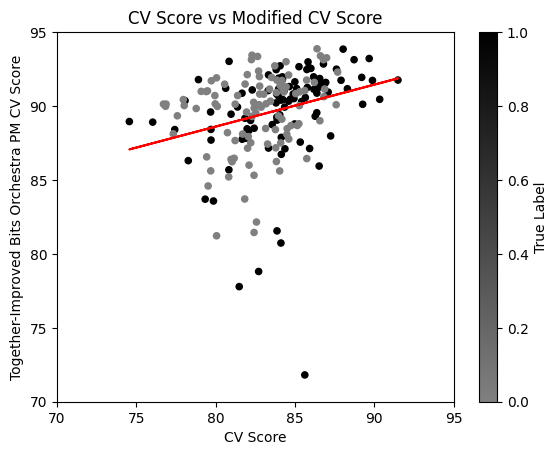

In [91]:
# Create a scatterplot of original score vs improved score
original_score_column_name = "CV Score"
modified_score_column_name = f"{constants.TAILORED_CV_NAME} Score"

all_scatterpoints: pd.DataFrame = scored_df.loc[scored_df["Marked for Experiments"], [original_score_column_name, modified_score_column_name, "True Label"]]

# Portray positive label as black and negative label as gray
from matplotlib.colors import LinearSegmentedColormap
POSITIVE_SCATTERPOINT_COLOR = "black"
NEGATIVE_SCATTERPOINT_COLOR = "gray"
positive_negative_colormap = LinearSegmentedColormap.from_list("Positive-Negative", [(constants.NEGATIVE_LABEL, NEGATIVE_SCATTERPOINT_COLOR), (constants.POSITIVE_LABEL, POSITIVE_SCATTERPOINT_COLOR)])

# Take nice square graph boundaries
x_min = all_scatterpoints[original_score_column_name].min()
x_max = all_scatterpoints[original_score_column_name].max()
y_min = all_scatterpoints[modified_score_column_name].min()
y_max = all_scatterpoints[modified_score_column_name].max()

import math
INCREMENT = 5
lower_boundary = math.floor( (min(x_min, y_min) - 0.1) / INCREMENT) * INCREMENT
upper_boundary = math.ceil( (max(x_max, y_max) + 0.1) / INCREMENT) * INCREMENT

score_scatterplot_axes = all_scatterpoints.plot.scatter(x = original_score_column_name, y = modified_score_column_name, 
                                                    c = "True Label", colormap = positive_negative_colormap,
                                                    title = "CV Score vs Modified CV Score",
                                                    xlim = (lower_boundary, upper_boundary), ylim = (lower_boundary, upper_boundary)
                                                    )

# Run linear regression on the combined 200 points
from sklearn.linear_model import LinearRegression
X = all_scatterpoints[[original_score_column_name]].values      # Reshaped into 2D array
y = all_scatterpoints[modified_score_column_name].values        # 1D array

linear_regression_model = LinearRegression()
linear_regression_model.fit(X, y)

# Get the coefficients
linear_regression_slope = linear_regression_model.coef_[0]
linear_regression_intercept = linear_regression_model.intercept_
linear_regression_coefficient_of_determination = linear_regression_model.score(X, y)

print(f"Slope: {linear_regression_slope}")
print(f"Intercept: {linear_regression_intercept}")
print(f"Coefficient of determination: {linear_regression_coefficient_of_determination}")

# Plot the combined plot
import matplotlib.pyplot as plt
predictions = linear_regression_model.predict(X)
score_scatterplot_axes.plot(X, predictions, color='red', label='Regression Line')

plt.show()

In [22]:
# Export the original positive CV scores to a file
original_cv_scores: pd.Series = scored_df.loc[scored_df["CV Score"].notna(),"CV Score"]

ORIGINAL_CV_SCORES_OUTPUT_FILENAME = "data/project manager 100 original CV scores.csv"
original_cv_scores.to_csv(ORIGINAL_CV_SCORES_OUTPUT_FILENAME)

In [29]:
# Import the original positive CS scores from a file
ORIGINAL_CV_SCORES_INPUT_FILENAME = "data/project manager 100 original CV scores.csv"
original_cv_scores = pd.read_csv(ORIGINAL_CV_SCORES_INPUT_FILENAME)["CV Score"]

In [3]:
top20df = raw_df.groupby("Position").count().sort_values("Moreinfo", ascending=False).head(20)

In [28]:
# Read in the parquet
RESUMES_PARQUET_INPUT_FILENAME = "data/resumes.parquet"
raw_df = pd.read_parquet(RESUMES_PARQUET_INPUT_FILENAME, engine='pyarrow')  # raw dataframe

# Filter the dataframe by minimum cv length
MIN_CV_LENGTH = 500
filtered_df = raw_df.loc[raw_df['CV'].dropna().apply(len) >= MIN_CV_LENGTH]

# Add a true label column based on the specified keywords

import testing_scripts.label_resumes
# import importlib
# importlib.reload(testing_scripts.label_resumes)

labeled_df = filtered_df.copy()
testing_scripts.label_resumes.add_true_label_column(labeled_df, constants.POSITIVE_POSITION, constants.POSITIVE_KEYWORD, ["UI/UX Designer", "UX/UI Designer"], "Design", verbose = False)

# Filter out entries whose true label is NA (i.e. belongs to neither class)
labeled_df = labeled_df[labeled_df["True Label"].notna()]

In [29]:
labeled_df["True Label"].value_counts()

True Label
1    8897
0    6910
Name: count, dtype: int64

In [14]:
# Mark only 100 of the NEGATIVES for scoring
# How many samples from each class we want to mark for experiments
NUM_POSITIVE_SAMPLES = 0
NUM_NEGATIVE_SAMPLES = 100

# Create a new column "Marked for Experiments" and deterministically mark 
# the first NUM_POSITIVE_SAMPLES positive entries and the first NUM_NEGATIVE_SAMPLES negative entries True and all others false
labeled_df["Marked for Experiments"] = False
positive_sample_indices = labeled_df[labeled_df["True Label"] == constants.POSITIVE_LABEL].index[:NUM_POSITIVE_SAMPLES]
negative_sample_indices = labeled_df[labeled_df["True Label"] == constants.NEGATIVE_LABEL].index[:NUM_NEGATIVE_SAMPLES]
labeled_df.loc[positive_sample_indices, "Marked for Experiments"] = True
labeled_df.loc[negative_sample_indices, "Marked for Experiments"] = True
marked_df = labeled_df          # alias

# Export the marked dataframe
MARKED_DATAFRAME_OUTPUT_FILENAME = "data/marked_df_only_UIUX_designer.csv"
marked_df.to_csv(MARKED_DATAFRAME_OUTPUT_FILENAME)

In [15]:
marked_df.loc[marked_df["Marked for Experiments"]]

,Position,Moreinfo,Looking For,Highlights,Primary Keyword,English Level,Experience Years,CV,CV_lang,id,__index_level_0__,True Label,Marked for Experiments
26710,"Designer, web designer, UI/UX designer","I have some experience in commercial projects,...",None,I am a graphic designer currently pursuing my ...,Design,basic,0.5,I am a graphic designer currently pursuing my ...,en,5a0a2240-1a98-53d6-98fa-e670b148b73f,50940,0,True
26728,Design Lead/ Art Director/ Senior UX/UI designer,"-Team Leadership,\r\n-Project management,\r\n-...",I'm looking for a company that provides plenty...,My design journey began 10 ago since the Colle...,Design,fluent,6.0,My design journey began 10 ago since the Colle...,en,b8a5411a-ac23-599e-ada0-e100481f73bc,50958,0,True
26746,Design manager / Lead Product Designer / UX/UI...,I'm experienced product designer and design te...,Willing to apply my manager experience in deli...,More than 30 successfully finished projects\r\...,Design,upper,8.0,More than 30 successfully finished projects\r\...,en,a05f865a-6b1f-581e-83cf-f60ed0d75b1d,50976,0,True
26747,"Design Manager, Lead UI/UX Designer","Over 6+ years of commercial experience, based ...",None,• 8 Design Awards on Behance\r\n• Honorable me...,Design,fluent,7.0,• 8 Design Awards on Behance\r\n• Honorable me...,en,fa43d2a5-208f-5062-b335-23998329a6b9,50977,0,True
26760,"Design team lead, graphic designer, ux/ui desi...",I have an extensive experience in graphic and ...,I want to join a team of entusiasts and ambiti...,"• During my professional career, I have create...",Design,intermediate,11.0,"• During my professional career, I have create...",en,e5c3f817-38d9-51c6-8285-fc3ec884feee,50990,0,True


In [9]:
labeled_df.loc[labeled_df["True Label"] == 0]

,Position,Moreinfo,Looking For,Highlights,Primary Keyword,English Level,Experience Years,CV,CV_lang,id,__index_level_0__,True Label,Marked for Experiments
26710,"Designer, web designer, UI/UX designer","I have some experience in commercial projects,...",None,I am a graphic designer currently pursuing my ...,Design,basic,0.5,I am a graphic designer currently pursuing my ...,en,5a0a2240-1a98-53d6-98fa-e670b148b73f,50940,0,True
26728,Design Lead/ Art Director/ Senior UX/UI designer,"-Team Leadership,\r\n-Project management,\r\n-...",I'm looking for a company that provides plenty...,My design journey began 10 ago since the Colle...,Design,fluent,6.0,My design journey began 10 ago since the Colle...,en,b8a5411a-ac23-599e-ada0-e100481f73bc,50958,0,True
26746,Design manager / Lead Product Designer / UX/UI...,I'm experienced product designer and design te...,Willing to apply my manager experience in deli...,More than 30 successfully finished projects\r\...,Design,upper,8.0,More than 30 successfully finished projects\r\...,en,a05f865a-6b1f-581e-83cf-f60ed0d75b1d,50976,0,True
26747,"Design Manager, Lead UI/UX Designer","Over 6+ years of commercial experience, based ...",None,• 8 Design Awards on Behance\r\n• Honorable me...,Design,fluent,7.0,• 8 Design Awards on Behance\r\n• Honorable me...,en,fa43d2a5-208f-5062-b335-23998329a6b9,50977,0,True
26760,"Design team lead, graphic designer, ux/ui desi...",I have an extensive experience in graphic and ...,I want to join a team of entusiasts and ambiti...,"• During my professional career, I have create...",Design,intermediate,11.0,"• During my professional career, I have create...",en,e5c3f817-38d9-51c6-8285-fc3ec884feee,50990,0,True


,Position,Moreinfo,Looking For,Highlights,Primary Keyword,English Level,Experience Years,CV,CV_lang,id,__index_level_0__,True Label,Marked for Experiments
26710,"Designer, web designer, UI/UX designer","I have some experience in commercial projects,...",None,I am a graphic designer currently pursuing my ...,Design,basic,0.5,I am a graphic designer currently pursuing my ...,en,5a0a2240-1a98-53d6-98fa-e670b148b73f,50940,0,True
26728,Design Lead/ Art Director/ Senior UX/UI designer,"-Team Leadership,\r\n-Project management,\r\n-...",I'm looking for a company that provides plenty...,My design journey began 10 ago since the Colle...,Design,fluent,6.0,My design journey began 10 ago since the Colle...,en,b8a5411a-ac23-599e-ada0-e100481f73bc,50958,0,True
26746,Design manager / Lead Product Designer / UX/UI...,I'm experienced product designer and design te...,Willing to apply my manager experience in deli...,More than 30 successfully finished projects\r\...,Design,upper,8.0,More than 30 successfully finished projects\r\...,en,a05f865a-6b1f-581e-83cf-f60ed0d75b1d,50976,0,True
26747,"Design Manager, Lead UI/UX Designer","Over 6+ years of commercial experience, based ...",None,• 8 Design Awards on Behance\r\n• Honorable me...,Design,fluent,7.0,• 8 Design Awards on Behance\r\n• Honorable me...,en,fa43d2a5-208f-5062-b335-23998329a6b9,50977,0,True
26760,"Design team lead, graphic designer, ux/ui desi...",I have an extensive experience in graphic and ...,I want to join a team of entusiasts and ambiti...,"• During my professional career, I have create...",Design,intermediate,11.0,"• During my professional career, I have create...",en,e5c3f817-38d9-51c6-8285-fc3ec884feee,50990,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
138261,Project Manager (with QA background),For the last year I've been working as Project...,"I'm interested in Project management role, pre...",I was promoted from QA Lead to Project manager...,Project Manager,upper,3.0,I was promoted from QA Lead to Project manager...,en,ca5ff76a-2dbe-5857-9107-aeb61060383c,162491,1,False
138262,Project manager (with sales background). Locat...,"German, English, workflow from researching to ...","As I am in Germany right now, I am open to the...",- development of sales department from 0. \r\n...,Project Manager,fluent,8.0,- development of sales department from 0. \r\n...,en,0f4976a2-b705-5417-afba-658af236c5ab,162492,1,False
138263,Project Manager with tech skills in Web develo...,"Pet Projects:\r\nWeb Studio\r\n[HTML, CSS, SAS...","With some experience behind me, now I am looki...",-Successfully led and delivered multiple softw...,Project Manager,upper,0.5,-Successfully led and delivered multiple softw...,en,dcadc8a0-5252-5c25-9448-a1e66a9e8fd0,162493,1,False
138264,"Project Manager ,Ассистент менеджера проектов.",Period: 04.2015 - 04.2020\r\nOrganization: Exp...,None,None,Project Manager,basic,2.5,\nPeriod: 04.2015 - 04.2020\r\nOrganization: E...,en,b450d17e-786f-505b-85be-5f5071af7871,162494,1,False
